# 1. Assume that the inputs $X$ to some scalar function $f$ are $n*m$ matrices. What is the dimensionality of the gradient of $f$ with respect to $X$?

The dimensionality of the gradient of $f$ with respect to $X$ remains $n \times m$, which matches the dimensionality of the input matrix $X$.

# 2. Add a bias to the hidden layer of the model described in this section (you do not need to include bias in the regularization term).
- Draw the corresponding computational graph.
- Derive the forward and backward propagation equations.

In [1]:
import sys
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import warnings
from torchviz import make_dot
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
warnings.filterwarnings('ignore')

class WeightDecayMLPScratch(d2l.MulMLPScratch):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__(num_inputs, num_outputs, num_hiddens, lr, sigma=0.01)
        
    def loss(self, y_hat, y, averaged=True):
        y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
        y = y.reshape((-1,))
        return F.cross_entropy(y_hat, y, reduction='mean' 
                               if averaged else 'none') + sum([w.norm().item() for iw in self.W])

/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/d2l.py:122: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'net'), 'Neural network is defined'
/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/d2l.py:126: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'trainer'), 'trainer is not inited'


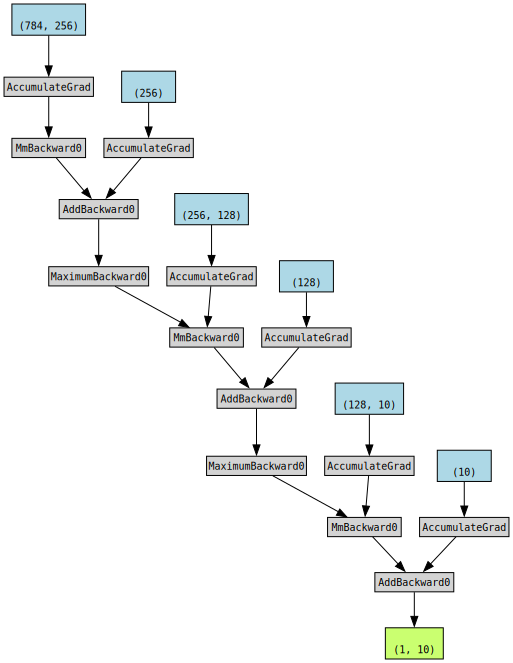

In [11]:
input_shape = 28*28
model = WeightDecayMLPScratch(num_inputs = input_shape, num_outputs=10, num_hiddens=[256,128], lr=0.1)

x = torch.randn(1, 28*28)
y = model(x)
make_dot(y, params=dict(model.named_parameters()))

**Forward Propagation:**

1. **Input to Hidden Layer:**$z = W^{(1)}x + b^{(1)}$
2. **Hidden Layer Activation:**$h = \phi(z) $
3. **Hidden to Output Layer:**$o = W^{(2)}h + b^{(2)}$
4. **Loss Calculation:**$\mathcal{L} = \frac{1}{2} (y - o)^2 + \frac{\lambda}{2}(||W^{(1)}||_F^2+||W^{(2)}||_F^2) $

**Backward Propagation (Gradient Descent):**

1. **Gradient of Loss with Respect to Output:**$\frac{\partial \mathcal{L}}{\partial o} = o - y $

2. **Gradient of Output with Respect to Hidden Layer:**$\frac{\partial o}{\partial h} = W^{(2)} $

3. **Gradient of Hidden Layer with Respect to Hidden Layer Activation:**$\frac{\partial h}{\partial z} = \phi(z)'$

4. **Gradient of Loss with Respect to Hidden Layer Activation:**
$\frac{\partial \mathcal{L}}{\partial h} = \frac{\partial \mathcal{L}}{\partial o} \cdot \frac{\partial o}{\partial h}$

5. **Gradient of Loss with Respect to Hidden Layer Weights:**
$\frac{\partial \mathcal{L}}{\partial W^{(1)}} = \frac{\partial \mathcal{L}}{\partial h} \cdot \frac{\partial h}{\partial z} \cdot x^T $

6. **Gradient of Loss with Respect to Hidden Layer Bias:**
$ \frac{\partial \mathcal{L}}{\partial b^{(1)}} = \frac{\partial \mathcal{L}}{\partial h} \cdot \frac{\partial h}{\partial z} $

# 3. Compute the memory footprint for training and prediction in the model described in this section.

In [5]:
from torchsummary import summary
model = d2l.MulMLP(num_outputs=10, num_hiddens=[256,128], lr=0.1)
summary(model, input_size=(1,28*28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


# 4. Assume that you want to compute second derivatives. What happens to the computational graph? How long do you expect the calculation to take?

When you want to compute second derivatives in the context of a neural network's computational graph, the graph becomes more complex and the calculation time significantly increases compared to computing first derivatives. This is because second derivatives involve the gradients of gradients, leading to a higher computational cost and potentially numerical instability.

Here's what happens to the computational graph and the expected calculation time when computing second derivatives:

1. **Computational Graph Complexity:**
   The computational graph becomes deeper and more complex as it needs to capture not only the relationships between the parameters and the loss but also the relationships between the gradients and their gradients. This leads to a larger memory footprint and more computational steps in backpropagation.

2. **Calculation Time:**
   The calculation time for second derivatives increases significantly compared to first derivatives. Computing second derivatives involves additional backpropagation steps for the gradients of gradients. Each parameter update requires additional computation and memory storage for both forward and backward passes. As the network architecture and the number of parameters increase, the computation time for second derivatives grows exponentially.

3. **Numerical Stability Concerns:**
   When computing second derivatives, numerical instability can become a concern. Small errors in the gradients of gradients can accumulate, potentially leading to issues such as vanishing or exploding gradients. Additionally, numerical precision issues can arise due to repeated differentiation.

4. **Higher Memory Usage:**
   Second derivative computations require additional memory to store intermediate gradients during the backward pass. This can lead to increased memory usage, especially for larger networks or when working with limited GPU memory.

5. **Longer Training Times:**
   The increased computational complexity and calculation time for second derivatives can significantly slow down the training process. This can affect the efficiency of optimization algorithms that rely on second-order information.

Due to the aforementioned challenges, directly computing second derivatives in deep neural networks is often avoided or replaced with approximate methods. Some optimization techniques, like the Hessian-free optimization, use efficient ways to approximate second-order information without explicitly computing second derivatives.

In summary, while second derivatives provide valuable information about the curvature of the loss landscape, their computation comes with significant computational and numerical challenges, particularly for deep neural networks with many parameters.

# 5. Assume that the computational graph is too large for your GPU.
- Can you partition it over more than one GPU?
- What are the advantages and disadvantages over training on a smaller minibatch?

If the computational graph of a neural network is too large to fit into a single GPU's memory, there are a few strategies you can consider to handle this situation:

1. **Model Parallelism:** Model parallelism involves splitting the neural network across multiple GPUs, where each GPU handles a portion of the model. This is commonly used when the model itself is too large to fit into the memory of a single GPU.

2. **Data Parallelism:** Data parallelism involves dividing the training data into smaller batches and distributing those batches across multiple GPUs. Each GPU computes gradients for its batch, and the gradients are then averaged or summed across GPUs to update the model's parameters.

3. **Hybrid Parallelism:** This approach combines both model parallelism and data parallelism, where a large model is divided among GPUs, and each GPU handles multiple batches of data.

4. **Gradient Accumulation:** If you can't fit a large minibatch into a single GPU's memory, you can perform gradient accumulation. This involves calculating gradients for smaller minibatches and then accumulating these gradients over multiple iterations before performing a parameter update.

**Advantages of Partitioning over Multiple GPUs:**

- **Memory Efficiency:** Partitioning the model or data over multiple GPUs allows you to work with larger models or datasets that wouldn't fit in a single GPU's memory.
- **Parallelism:** Training on multiple GPUs can lead to faster training times due to parallel computation.
- **Flexibility:** You can leverage existing GPUs without needing to invest in a single large GPU.

**Disadvantages of Partitioning over Multiple GPUs:**

- **Communication Overhead:** There's a communication overhead when exchanging information (e.g., gradients) between GPUs, which can slow down training.
- **Synchronization Challenges:** Synchronizing multiple GPUs can be complex, especially when dealing with asynchronous updates.
- **Code Complexity:** Writing code for distributed training and handling GPU synchronization can be more challenging and error-prone.
- **Hardware Dependencies:** This approach requires multiple GPUs, which might not be available in all environments.

**Advantages of Training on a Smaller Minibatch:**

- **Lower Memory Usage:** Training on smaller minibatches reduces the memory requirements, allowing you to fit the model and data on a single GPU.
- **More Frequent Updates:** Smaller minibatches lead to more frequent updates, which can help the model converge faster.
- **Less Communication Overhead:** When working with a single GPU, you don't have the communication overhead associated with distributing computations over multiple GPUs.

**Disadvantages of Training on a Smaller Minibatch:**

- **Slower Convergence:** Smaller minibatches can lead to more noisy gradient estimates, slowing down convergence.
- **Possibility of Overfitting:** Training on smaller minibatches might result in overfitting, as the model doesn't see a diverse range of examples in each update.

Ultimately, the choice between partitioning over multiple GPUs and training on a smaller minibatch depends on your hardware resources, computational requirements, and the specific characteristics of your problem. It's important to carefully consider the trade-offs and experiment to find the best approach for your situation.